# Final project -- Numerical Analysis -- 2020/2021

## General goal

Consider the hyper-cube $\Omega := [-1,1]^d$ in dimension `d`.

Given a function $f: \Omega \mapsto R$, find $u: \Omega \mapsto R$ such that 

$
- \Delta u  + u = f, \text{ in } \Omega
$

$
\frac{\partial u}{\partial n} = 0 \text{ on } \partial \Omega
$

using Chebyshev spectral elements, and in a matrix-free framework.

## Due date: 

- MHPC students: 20 February 2021
- DSSC/LM/PHD students: 1 day before the oral examination

## General definitions

We recall here some general definitions that will be useful throughout the project.

- The space $Q^p(\Omega)$ is the space of polynomials of order $p$ in each coordinate direction. The dimension of $Q^p$ is $(p+1)^d$ where $d$ is the dimension of the space. 

- A tensor product basis for $Q^p(\Omega)$ can be constructed from a basis for $P^p([-1,1])$, by arranging the indices in d-dimensional arrays, i.e., if $\{v_i\}_{i=0}^p$ is a basis for $P^p([-1,1])$, then, for example, 
$
v_{ijk} := v_i(x_0)v_j(x_1)v_k(x_2)
$
is a basis for $Q^p([-1,1]^3)$.

- Chebyshev points of type 2 are Chebishev points in one dimension that include end points. These are not minimizers of the linfty norm of the Lebesgue function (those are Chebishev points of type 1), but are minimizers of Lebesgue function when you constrain two of the points to coincide with the extremes of the interval $[-1,1]$. You can obtain those points by calling `numpy.polynomial.chebyshev.chebpts2`.

- Chebyshev spectral elements are the tensor product basis for $Q^p(\Omega)$, generated by the Lagrange basis functions constructed using as support points the Chebyshev points of type 2. In one dimension, for degree=5, npoints=6, they look like

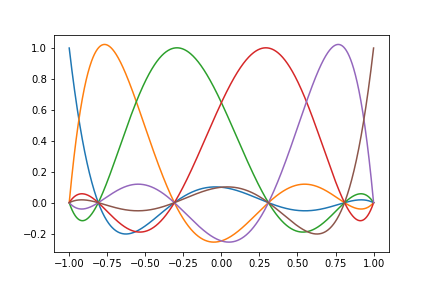

- Integration in each coordinate direction can be performed using Gauss quadrature formulas, which can be queried by the function `numpy.polynomial.legendre.leggauss`. That function returns a tuple of two objects,  containing both the quadrature points `q` and the quadrature weights `w`, i.e., `q, w = numpy.polynomial.legendre.leggauss(nq)`.

- The construction of a Lagrange basis can be done easily by calling `scipy.interpolate.lagrange(X, ei)` where `X` are the interpolation points, and `ei` is a vector containing all zeros, except a one in the position corresponding to the index i. For example, the following code 

~~~
X = numpy.polynomial.chebyshev.chebpts2(6)
e_3 = zeros((6,))
e_3[3] = 1

B_3 = lagrange(X, e_3)
B_3_prime = polyder(B_3)

x = linspace(-1,1,501)
plot(x, B_3(x))
plot(X, 0*X, 'ro')
figure()
plot(x, B_3_prime(x))
plot(X, 0*X, 'ro')
~~~

will produce the following pictures

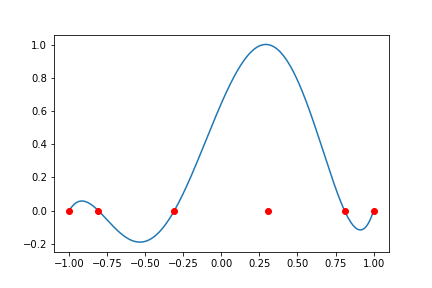

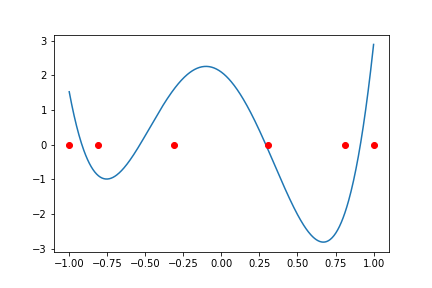

Which correspond to the fourth (`index=3`) Chebishev spectral basis function and its derivative, for the space $P^5([-1,1])$.

The functions `B_3` and `B_3_prime` computed above are callable functions, i.e., you can evaluate the basis and its derivative as normal functions, and they accept as input numpy arrays.

## Weak formulation

The weak form of the problem reads:

Given $f:\Omega \mapsto R$, find $u\in H^1(\Omega)$ such that

$
\int_\Omega \nabla u \cdot \nabla v + \int_\Omega u v = \int_\Omega f v \qquad \forall v \in H^1(\Omega)
$

## Discrete weak formulation (one dimensional case)

Given a finite dimensional space $V_h \subset H^1([-1,1])$ such that  $V_h = \text{span}\{v_i\}_{i=0}^p$, then
the discrete problem reads:

Find $u$ such that

$
A u = f 
$

where $A$ is a matrix in  $R^{(p+1)\times(p+1)}$  and $f$ is a vector in $R^{(p+1)}$ 

$
A_{ij} = \int_\Omega \nabla v_j \cdot \nabla v_i+\int_\Omega  v_j  v_i, \qquad f_i = \int_\Omega f v_i
$

that is (using a quadrature with $q_\alpha$ and $w_\alpha$ as points and weights):

$
A_{ij} = \sum_{\alpha=0}^{nq-1}\left( v'_j(q_\alpha) v'_i(q_\alpha)+  v_j(q_\alpha)  v_i(q_\alpha)\right)w_\alpha
$

$
f_{i} = \sum_{\alpha=0}^{nq-1} v_j(q_\alpha) f(q_\alpha) w_\alpha
$

Let's assume we have computed the matrices $B_{i\alpha} := v_i(q_\alpha)$, and $D_{i\alpha} := v'_i(q_\alpha)$ containing the evaluation of all basis functions and of their derivatives in the quadrature points $q_\alpha$.  

The matrix $A$ can then be written as

$
A_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha + B_{i\alpha} B_{j\alpha} w_\alpha\right) = K_{ij} + M_{ij}
$

where $K$ is usually known as the one dimensional stiffness matrix, and $M$ as the one dimensional mass matrix:


$
K_{ij} = \sum_\alpha \left(D_{i\alpha} D_{j\alpha} w_\alpha \right)
$


$
M_{ij} = \sum_\alpha \left(B_{i\alpha} B_{j\alpha} w_\alpha \right)
$

Using numpy and Lapack, these can be computed efficiently by calling `einsum`:

~~~
K = einsum('iq, q, jq', D, w, D)
M = einsum('iq, q, jq', B, w, B)
~~~

where the function `einsum` interprets the first argument (a string) as a list of indices over which sum should occur. The list must be of the same length of the other arguments (3 in this case), and the number of indices for each entry musth match the input (i.e., `iq` for `D`, and `q` for `w`). The three arrays are multiplied entry by entry, and if an index is repeated in the description, those entries are summed over (see the documentation).

## Higher dimensional case

If we have already computed the one dimensional matrices $B_{i\alpha} = v_i(q_\alpha)$ and $D_{i\alpha} := v'_i(q_\alpha)$ we can compute easily the 2 and 3 dimensional versions of the stiffness, mass, and system matrices.

In particular, defining $q_{\alpha\beta} := (q_\alpha, q_\beta)$, and $w_{\alpha\beta} = w_\alpha w_\beta$, we have

$\nabla v_{ij}(q_{\alpha\beta}) \cdot \nabla v_{kl}(q_{\alpha\beta}) := v'_i(q_{\alpha})v_j(q_{\beta})v'_k(q_{\alpha})v_l(q_{\beta}) + v_i(q_{\alpha})v'_j(q_{\beta})v_k(q_{\alpha})v'_l(q_{\beta})$. 

Integrating with quadrature twice (once for each dimension), we get:

$
K_{ij,kl} := \sum_q \sum_p v'_i(X_q)v_j(X_p)v'_k(X_q)v_l(X_p) + v_i(X_q)v'_j(X_p)v_k(X_q)v'_l(X_p) w_p w_q
$

These are easily expressed directly through python `einsum`, i.e., 

```
KM = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, D, B)
MK = einsum('iq, jp, q, p, kq, lp -> ijkl', D, B, w, w, B, D)
KK = KM+MK
```

Or, if we have already the one dimensional matrices $K_{ij}$ and $M_{ij}$, then the above become:

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which, using the `einsum` command, becomes:

```
KM = einsum('ik, jl -> ijkl', K, M)
MK = einsum('ik, jl -> ijkl', M, K)
MM = einsum('ik, jl -> ijkl', M, M)
KK = KM+MK
AA = KK+MM

```

The resulting array can be reshaped to a two dimensional matrix by calling `AA.reshape((n**2, n**2))`, and solved for using `linalg.solve`.

Similarly in 3 dimensions:


$
A_{ijk,lmn} := (K_{il}M_{jm}M_{kn}+M_{il}K_{jm}M_{kn}+M_{il}M_{jm}K_{kn})+M_{il}M_{jm}M_{kn}
$

Sums of the kind $D_{ijk,lmn} = A_{il}B_{jm}C_{kn}$ can be expressed using `einsum` as

```
D = einsum('il, jm, kn -> ijklmn', A, B, C)
```

And the resulting six-dimensional array can be reshaped to a matrix by calling `D.reshape((n**3, n**3))`.

## Intermediate assignments

### 1. One dimensional matrices
Write a function that, given the number of Chebishev points `n`, returns `K`, `M`, and `A` for a one dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points 

In [27]:
%pylab inline


import numpy as np
import matplotlib.pyplot as plt

from numpy.polynomial.legendre import leggauss
from scipy import interpolate
from scipy import integrate
from scipy.interpolate import KroghInterpolator

#from collections import namedtuple

import sympy as sym
import sympy.abc


from timeit import default_timer as timer 
from numba import jit, njit, cuda

Populating the interactive namespace from numpy and matplotlib


In [2]:
#returns the lagrange basis of degree n
#with chebychev points as nodes
def get_lagrange_basis(n):
    bases_nodes_val = np.zeros((n,1),dtype=np.float64)
    nodes = np.polynomial.chebyshev.chebpts2(n)
    basis = []
        
    for i in range(n):
        bases_nodes_val[i]=1
        basis.append( interpolate.lagrange(nodes, bases_nodes_val) )
        bases_nodes_val[i]=0

    return basis


'''
computes the matrices for a "reference FEM element"
assumes the interval is -1,1
gets the cheychev points of type 2
gets the gaussian quadrature points and weights
computes the i-th basis func nd its derivative and evals them
computes the sum o
on the quad points
'''  

def compute_one_dimensional_matrices(n):
    #n chebichev points
    #n quadrature points
    
    
    #nodes = np.polynomial.chebyshev.chebpts2(n)
    quad_p, quad_w = leggauss(n)   
    
    #bases_nodes_val = np.zeros((n,1),dtype=np.float64)
    
    B = np.zeros((n,n),dtype=np.float64)
    D = np.zeros((n,n),dtype=np.float64)
    
    lag_basis = get_lagrange_basis(n)
    
    for i in range(n):
        #bases_nodes_val[i]=1
        
        B[i,:] = lag_basis[i](quad_p)
        
        base_i_prime = np.polyder(lag_basis[i])
        D[i,:] = base_i_prime(quad_p)
    
        #bases_nodes_val[i]=0
                
    
    K = np.zeros((n, n), dtype=np.float64)
    M = np.zeros((n, n), dtype=np.float64)
    A = np.zeros((n, n), dtype=np.float64)
        
    
    K = np.einsum('iq, q, jq -> ij', D, quad_w, D)
    M = np.einsum('iq, q, jq -> ij', B, quad_w, B)
    

    
    A = K + M


    return B, K, M, A




### 2. Error in one dimension

Using 

$
u_{exact}(x) = \cos(\pi x)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

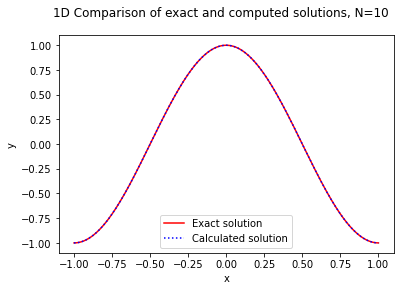

size:  10
size:  11
size:  12
size:  13
size:  14
size:  15
size:  16
size:  17
size:  18
size:  19
size:  20


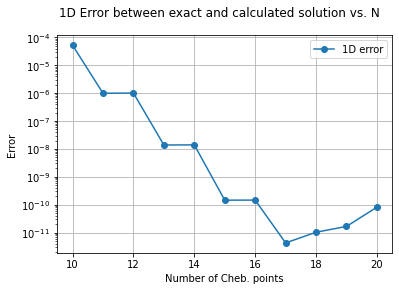

In [15]:

def exact_one_d(x):
    return np.array( np.cos(np.pi*x), dtype=np.float64 )
    

def forcing_one_d(xvec):
    return exact_one_d(xvec)*(1 + np.pi**2)

'''
given the number of chebychev nodes and the handle to the forcing 
function of the system, integrates by quadrature the forcing functon
'''
def compute_one_dimensional_RHS_(n, B, force_f):
    #nodes = np.polynomial.chebyshev.chebpts2(n)
    quad_p, quad_w = leggauss(n)   
        
    return np.einsum('iq, q, q -> i', B, force_f( quad_p ), quad_w) 


def oned_compute_solution(n, force_f):
    
    #assemble the matrices
    B,K,M,A = compute_one_dimensional_matrices(n)
    
    #compute the rhs
    rhs = compute_one_dimensional_RHS_(n, B, force_f )
    
    #solve the system
    coef_sol = np.linalg.solve( A,rhs)

    
    #return just the coefficients
    return coef_sol
    
    
    
def oned_eval_solution(x, coef_sol):
    n = np.size(coef_sol)
    l = np.size(x)
    
    #construct the lagrangian basis
    lag_basis = get_lagrange_basis(n)
    
    #sum the basis times the calculated coefficients
    sol_eval = np.zeros((l), dtype= np.float64)
    for i in range(0,n):
        sol_eval = sol_eval + coef_sol[i]*lag_basis[i](x) 
        
    return sol_eval
    
    


def compute_error_one_d(n, exact, rhs):
    # Replace this with you implementation
    
    print("size: ",n)
    
    coef_sol = oned_compute_solution(n,rhs)
    
    n_l2_quad_pts = n + 3 
    nodes = np.polynomial.chebyshev.chebpts2(n)
    l2_quad_p, l2_quad_w = leggauss(n_l2_quad_pts)
    
    #return np.linalg.norm(exact(l2_quad_p) - oned_eval_solution(l2_quad_p, coef_sol), ord=2)
    
    #error_func = lambda x: ( exact(x) - oned_eval_solution(x, coef_sol) )**2

    #l2_sq_err = integrate.quad(error_func, -1, 1, 1.0e-5)
    
    
    quad_eval_ex = exact(l2_quad_p)
    quad_eval_calc = oned_eval_solution(l2_quad_p, coef_sol)
    
    err_v = quad_eval_ex - quad_eval_calc
    
    err_sq_v = np.multiply(err_v,err_v)
        
    l2_sq_err = np.dot( err_sq_v , l2_quad_w )
    
    
    l2_error = np.linalg.norm( quad_eval_ex - quad_eval_calc, ord=2 )
    
    
    return np.sqrt( l2_sq_err)

    


# calculate a solution and plot it 
xvec = np.linspace(-1,1,501, dtype=np.float64 )

exact_sol_eval = exact_one_d(xvec)

calc_sol_eval = oned_eval_solution(xvec, oned_compute_solution(10, forcing_one_d))


plt.figure()          
ex_sol_h, = plt.plot(xvec,exact_sol_eval,'r')
calc_sol_h, = plt.plot(xvec,calc_sol_eval,'b:')
plt.suptitle('1D Comparison of exact and computed solutions, N=10')
plt.xlabel("x")
plt.ylabel("y")
plt.legend((ex_sol_h,calc_sol_h),('Exact solution','Calculated solution'))
plt.show()



error_1D = []
all_n = range(10,21)
for n in all_n:
    error_1D.append(compute_error_one_d(n, exact_one_d, forcing_one_d))
  
plt.grid()
plt.suptitle('1D Error between exact and calculated solution vs. N')
error_h = plt.semilogy(all_n, error_1D, 'o-',label='1D error')
plt.xlabel("Number of Cheb. points")
plt.ylabel("Error")
plt.legend()
plt.show()

### 3. Two dimensional matrices

Write a function that, given the number of Chebishev points `n` per each coordinate direction, returns `K`, `M`, and `A` for a two dimensional problem, integrated exactly using Gauss quadrature formulas with the correct number of quadrature points (as matrices, i.e., reshaped to be two dimensional)

In [8]:

def compute_two_dimensional_matrices(n,K,M):
    
    KM = np.einsum('ik, jl -> ijkl', K, M)
    MK = np.einsum('ik, jl -> ijkl', M, K)
    MM = np.einsum('ik, jl -> ijkl', M, M)
    KK = KM+MK
    AA = KK+MM
    
    KK = KK.reshape((n**2, n**2))
    MM = MM.reshape((n**2, n**2))
    AA = AA.reshape((n**2, n**2))
    

    return KK, MM, AA


### 3. Error in two dimension

Using 

$
u_{exact}(x) = \cos(\pi x_0)\cos(\pi x_1)
$

as the exact solution, compute the forcing term $f$ that should go on the right hand side of the system to ensure that the exact solution is $u$, i.e., $f = -\Delta u + u$  

Use $f$ to compute the right hand side of your problem, and solve the problem (using `linalg.solve`) for increasing numbers of Chebishev points. Compute the $L^2$ error between the exact solution and the computed approximatio, using a higher order quadrature w.r.t. what you used to assemble the matrices. 

A solution should look like:

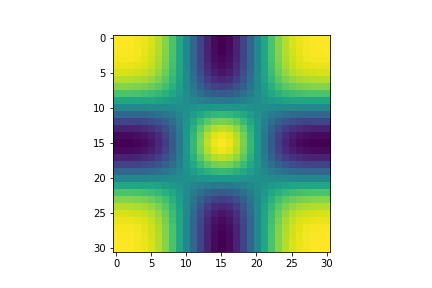

The plot was obtained as `imshow(u.reshape((n,n))`.

Plot the error as a function of $n$, for $n$ in $[10,...,20]$.

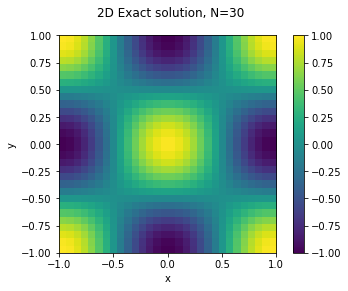

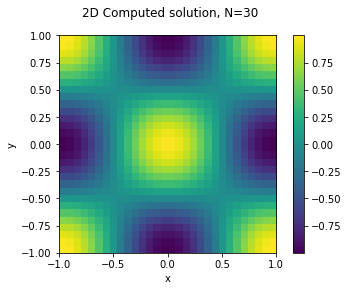

size:  10
size:  11
size:  12
size:  13
size:  14
size:  15
size:  16
size:  17
size:  18
size:  19
size:  20


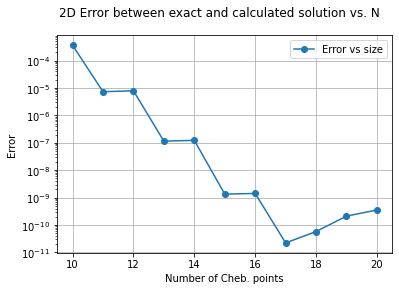

In [14]:

def exact_two_d(x,y):
    XX, YY = np.meshgrid(x, y)
    return np.cos(np.pi*XX)*np.cos(np.pi*YY)
    
def forcing_two_d(x,y):
    return exact_two_d(x,y)*(1 + 2*(np.pi**2))


'''
given the number of chebychev nodes and the handle to the forcing 
function of the system, integrates by quadrature the 2dim forcing function
'''
def compute_two_dimensional_RHS_(n, B, rhs_f):
    #nodes = np.polynomial.chebyshev.chebpts2(n)
    quad_p, quad_w = leggauss(n)   
        
    F_rhs = np.einsum('ia, jb, ab, a, b -> ij', B, B, rhs_f( quad_p, quad_p ), quad_w, quad_w) 
    
    #reshape the matrix into a linear array
    return F_rhs.reshape((n**2,))


def twod_compute_solution(n, rhs_f):
    
    #get the one-dimensional matrices
    B,K,M,A = compute_one_dimensional_matrices(n)
    
    #assemble the matrices
    KK,MM,AA = compute_two_dimensional_matrices(n,K,M)
    
    #compute the rhs
    rhs = compute_two_dimensional_RHS_(n, B, rhs_f )
    
    #solve the system
    coef_sol = np.linalg.solve( AA,rhs)
    
    
    #return just the coefficients, reshaped into a matrix 
    return coef_sol.reshape((n,n))

'''
evaluate the solution
construct the one dim lagrangian basis, construct a meshgrid given the x and y points
evaluating the product of two basis functions evaluated on the meshgrid gives an elem of the 
two-dim basis
'''
def twod_eval_solution(x,y, coef_sol):
    #get FEM degree and evaluation ponts sizes
    n = coef_sol.shape[0]
    lx = np.size(x)
    ly = np.size(y)
    
    XX, YY = np.meshgrid(x, y)

    #construct the 1D lagrangian basis
    lag_basis = get_lagrange_basis(n)
    
    
    #construct a list of lagrangian bases already evaluated
    twod_lag_basis_x = []
    twod_lag_basis_y = []
    for i in range(0,n):
        twod_lag_basis_x.append(lag_basis[i](XX))
        twod_lag_basis_y.append(lag_basis[i](YY))
    
    
    #sum the basis times the calculated coefficients
    sol_eval = np.zeros((lx,ly), dtype= np.float64)
    
    # assemble the element of the 2d lag basis by multiplying a pair of 1d elements
    # multiply by the solutionthe solution coef
    for i in range(0,n):
        for j in range(0,n):
            sol_eval = sol_eval + coef_sol[i,j]*twod_lag_basis_x[i]*twod_lag_basis_y[j]
        
    return sol_eval
    
    
    
def compute_error_two_d(n, exact, rhs):
    # Replace this with you implementation
    
    print("size: ",n)
    
    coef_sol = twod_compute_solution(n,rhs)
    
    n_l2_quad_pts = n + 3 
    nodes = np.polynomial.chebyshev.chebpts2(n)
    l2_quad_p, l2_quad_w = leggauss(n_l2_quad_pts)
    
    return np.linalg.norm(exact_two_d(l2_quad_p, l2_quad_p) - twod_eval_solution(l2_quad_p, l2_quad_p, coef_sol), ord=2)
    
    error_func = lambda x,y: ( exact_two_d(x, y) - twod_eval_solution(x, y, coef_sol) )**2
    

    l2_sq_err = integrate.dblquad(error_func, -1, 1, -1, 1)
     
    
    '''
    quad_eval_ex = exact_two_d(l2_quad_p, l2_quad_p)
    quad_eval_calc = twod_eval_solution(l2_quad_p, l2_quad_p, coef_sol)
    
    err_v = quad_eval_ex - quad_eval_calc
    
    err_sq_v = np.multiply(err_v,err_v)
        
    l2_sq_err = np.dot( err_sq_v , l2_quad_w )
    
    
    l2_error = np.linalg.norm( quad_eval_ex - quad_eval_calc, ord=2 )
    '''
    return np.sqrt( l2_sq_err)
    


    
# calculate the 2D exact solution and plot it 
nn = 30

xvec = np.linspace(-1,1,nn, dtype=np.float64 )
#xvec = np.polynomial.chebyshev.chebpts2(n)
yvec = xvec

exact_sol_2d_eval = exact_two_d(xvec, yvec)
ex_min, ex_max = -np.abs(exact_sol_2d_eval).max(), np.abs(exact_sol_2d_eval).max() 

plt.figure()    
ex_sol_h= plt.imshow(exact_sol_2d_eval,vmin = ex_min, vmax = ex_max, 
                 extent =[xvec.min(), xvec.max(), yvec.min(), yvec.max()])
plt.suptitle('2D Exact solution, N=30')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(ex_sol_h) 

plt.show()



# calculate the numerical solution and plot it 

calc_sol_2d_eval = twod_eval_solution(xvec,xvec, twod_compute_solution(10, forcing_two_d))
#calc_sol_2d_eval =forcing_two_d(xvec,xvec)

cl_min, cl_max = -np.abs(calc_sol_2d_eval).max(), np.abs(calc_sol_2d_eval).max() 

plt.figure()    
cl_sol_h= plt.imshow(calc_sol_2d_eval,vmin = cl_min, vmax = cl_max, 
                 extent =[xvec.min(), xvec.max(), yvec.min(), yvec.max()])
plt.suptitle('2D Computed solution, N=30')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(cl_sol_h) 
plt.show()


  
error_2D = []
all_n = range(10,21)
for n in all_n:
    error_2D.append(compute_error_two_d(n, exact_two_d, forcing_two_d))
    
plt.figure()
plt.grid()
error_h = plt.semilogy(all_n, error_2D, 'o-',label='Error vs size')
plt.suptitle('2D Error between exact and calculated solution vs. N')
plt.xlabel("Number of Cheb. points")
plt.ylabel("Error")
plt.legend()
plt.show()



### 4. Conjugate gradient

The conjugate gradient method does not require the knowledge of the matrix, but only of the result of the matrix vector product with the system matrix A. 

Implement a version of the conjugate gradient method that solves the linear system of the two dimensional problem (up to a given tolerance) by only using a function that implements the matrix vector product, i.e., given a `matvec` function, for example defined by  

~~~
def matvec(src):
    return A.dot(src)
~~~

build a conjugate gradient method that only uses the function `matvec` to evaluate `A.dot(src)`. 

In [12]:


def cg(matvec, b, x0, tol=1e-05, maxiter=10000):
    # inside this function, you can call matvec(b) to evaluate the matrix vector 
    L = len(b)
    
    x = np.zeros(L,dtype=np.float64)
    r = np.ones(L,dtype=np.float64)
    p = np.ones(L,dtype=np.float64)
    
    
    k=0;
    r = b - matvec(x0)
    x = x0
    p = r
    delta=np.linalg.norm(r, ord=2)
    while (k<maxiter and delta>tol):
        k=k+1
        
        alpha=np.dot(p,r)/np.dot(p,matvec(p))
        
        x = x + alpha*p
        
        r = r -  alpha*matvec(p)
        
        delta = np.linalg.norm(r, ord=2)
        
        beta = np.dot(matvec(p),r)/np.dot(matvec(p),p)
        
        p = r -  beta*p
        

        
    
    return x, k, delta

Conj-Grad iterations:  5
Stopping tolerance:  5.801562036138892e-11


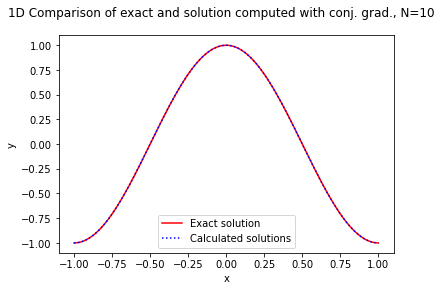

In [13]:
#test the conjugate gradient 

def oned_cg_compute_solution(n, force_f):
    
    #assemble the matrices
    B,K,M,A = compute_one_dimensional_matrices(n)
    
    #compute the rhs
    rhs = compute_one_dimensional_RHS_(n, B, force_f )
    
    #solve the system
    x0 = np.zeros(np.size(rhs), dtype=np.float64)
    coef_sol = cg( A.dot, rhs, x0 )

    
    #return just the coefficients
    return coef_sol
    

    
    


# calculate a solution and plot it 
xvec = np.linspace(-1,1,501, dtype=np.float64 )

exact_sol_eval = exact_one_d(xvec)

calc_coef, iters, delta = oned_cg_compute_solution(10, forcing_one_d)
calc_sol_eval = oned_eval_solution(xvec, calc_coef)

print("Conj-Grad iterations: ",iters)
print ("Stopping tolerance: ",delta)

plt.figure()          
ex_sol_h, = plt.plot(xvec,exact_sol_eval,'r')
calc_sol_h, = plt.plot(xvec,calc_sol_eval,'b:')
plt.suptitle('1D Comparison of exact and solution computed with conj. grad., N=10')
plt.xlabel("x")
plt.ylabel("y")
plt.legend((ex_sol_h,calc_sol_h),('Exact solution','Calculated solutions'))
plt.show()





### 5. "Matrix free" evaluation

Instead of assembling the two (or three dimensional) matrix, and then compute the matrix vector product using `A.dot(v)`, we can exploit the tensor product structure of the problem, and gain some computational time.

In particular, we exploit the fact that the two dimensional matrix is a `reshape` of the array

$
A_{ij,kl} := K_{ik}M_{jl} + M_{ik}K_{jl} + M_{ik}M_{jl}
$

which is constructed using the one dimensional matrices assembled at step 1.

Given an array `v`, it can be reshaped to a matrix of coefficients $v_{ij}$ in $R^{n\times n}$, and we can compute `A.dot(v)` as the sum $w_{ij} = \sum_{kl} A_{ij,kl} v_{kl}$

So `A.dot(v)` reduces to  series of one dimensional matrix-matrix and matrix vector products:


$
w_{ij}  = \sum_{kl} A_{ij,kl} v_{kl} = \sum_{kl} (K_{ik}M_{jl}v_{kl} + M_{ik}K_{jl}v_{kl} + M_{ik}M_{jl}v_{kl})
$

which can be rearranged as 

~~~
def matvec(vinput):
    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    # KT_Mv = K.dot(Mv)  # K is symmetric
    # MT_Kv = M.dot(Kv)  # M is symmetric
    # MT_Mv = M.dot(Mv)  # M is symmetric

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
~~~

Make a comparison of the timings between using the full two dimensional matrix `A` to compute the matrix vector product, VS using the compressed version above, as we increase `n` from 50 to 100.

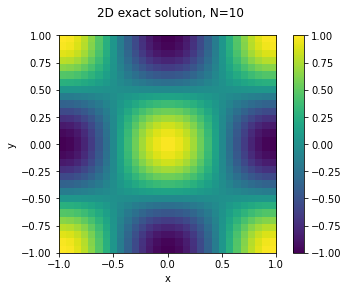

Conj-Grad iterations:  82
Stopping tolerance:  5.939749666055214e-06


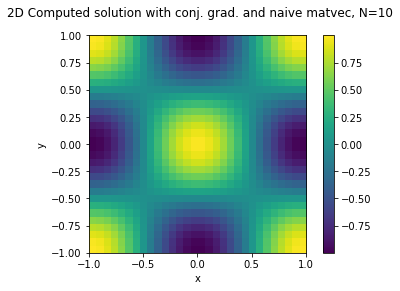

Conj-Grad iterations:  82
Stopping tolerance:  6.099482442813469e-06


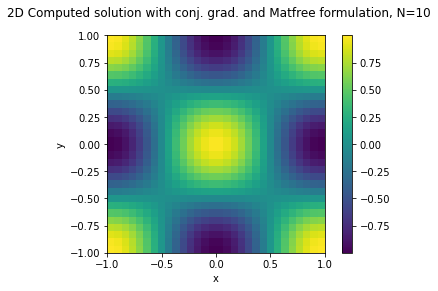

size:  10
size:  11
size:  12
size:  13
size:  14
size:  15
size:  16
size:  17
size:  18
size:  19
size:  20


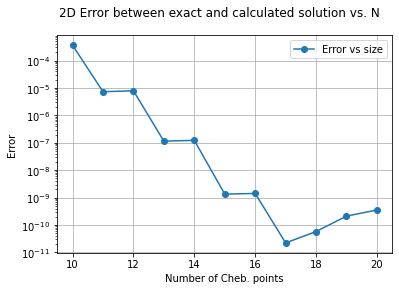

In [23]:

'''
#matrix-free product bw the 2-dim system matrix A and a vector
def matvec_matfree(vinput,K,M):
    n = int(np.sqrt(np.size(vinput)))

    v = vinput.reshape((n,n))

    Mv = M.dot(v) # result is n x n 
    Kv = K.dot(v) # result is n x n 

    u = K.dot(Mv)
    u += M.dot(Kv) 
    u += M.dot(Mv)
    return u.reshape((n**2,))
'''
    
#matrix-free product bw the 2-dim system matrix A and a vector
def matvec_matfree(vinput, K,M):
    n = int(np.sqrt(np.size(vinput)))
    v = vinput.reshape((n,n))
    

    vM = v.dot(M) # result is n x n 
    vK = v.dot(K) # result is n x n 

    u = K.dot(vM)
    u += M.dot(vK) 
    u += M.dot(vM)
    return u.reshape((n**2,))
    
 
    
def twod_cg_compute_solution(n, rhs_f):
    
    #get the one-dimensional matrices
    B,K,M,A = compute_one_dimensional_matrices(n)
    
    #assemble the matrices
    KK,MM,AA = compute_two_dimensional_matrices(n,K,M)
    
    #compute the rhs
    rhs = compute_two_dimensional_RHS_(n, B, rhs_f )
       
    
    #solve the system with conj. grad
    x0 = np.zeros(np.size(rhs), dtype=np.float64)
    coef_sol,iter ,delta = cg( AA.dot, rhs, x0 )
    
    
    #return just the coefficients, reshaped into a matrix 
    return coef_sol.reshape((n,n)), iter ,delta
    

def twod_cg_compute_solution_matfree(n, rhs_f):
    
    #get the one-dimensional matrices
    B,K,M,A = compute_one_dimensional_matrices(n)
    
    #compute the rhs
    rhs = compute_two_dimensional_RHS_(n, B, rhs_f )
    
    #create lambda function for the matrix multiplicator
    matvec = lambda vec: matvec_matfree( vec, K, M )
    
    
    #solve the system  with conj. grad
    x0 = np.zeros(np.size(rhs), dtype=np.float64)
    coef_sol,iter ,delta = cg( matvec, rhs, x0 )
    
    
    #return just the coefficients, reshaped into a matrix 
    return coef_sol.reshape((n,n)), iter ,delta
    
    
    
def compute_error_two_d_matfree(n, exact, rhs):
    # Replace this with you implementation
    
    print("size: ",n)
    
    coef_sol = twod_cg_compute_solution_matfree(n,rhs) 
    
    n_l2_quad_pts = n + 3 
    nodes = np.polynomial.chebyshev.chebpts2(n)
    l2_quad_p, l2_quad_w = leggauss(n_l2_quad_pts)
    
    return np.linalg.norm(exact_two_d(l2_quad_p, l2_quad_p) - twod_eval_solution(l2_quad_p, l2_quad_p, coef_sol), ord=2)
    
    error_func = lambda x,y: ( exact_two_d(x, y) - twod_eval_solution(x, y, coef_sol) )**2
    

    l2_sq_err = integrate.dblquad(error_func, -1, 1, -1, 1)
     
    
    '''
    quad_eval_ex = exact_two_d(l2_quad_p, l2_quad_p)
    quad_eval_calc = twod_eval_solution(l2_quad_p, l2_quad_p, coef_sol)
    
    err_v = quad_eval_ex - quad_eval_calc
    
    err_sq_v = np.multiply(err_v,err_v)
        
    l2_sq_err = np.dot( err_sq_v , l2_quad_w )
    
    
    l2_error = np.linalg.norm( quad_eval_ex - quad_eval_calc, ord=2 )
    '''
    return np.sqrt( l2_sq_err)



#compare the conj-grad solution vs the matfree solution vs the exact one 

# calculate the exact solution and plot it 
nn = 30

xvec = np.linspace(-1,1,nn, dtype=np.float64 )
#xvec = np.polynomial.chebyshev.chebpts2(n)
yvec = xvec

exact_sol_2d_eval = exact_two_d(xvec, yvec)
ex_min, ex_max = -np.abs(exact_sol_2d_eval).max(), np.abs(exact_sol_2d_eval).max() 

plt.figure()    
ex_sol_h= plt.imshow(exact_sol_2d_eval,vmin = ex_min, vmax = ex_max, 
                 extent =[xvec.min(), xvec.max(), yvec.min(), yvec.max()])
plt.suptitle('2D exact solution, N=10')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(ex_sol_h) 
plt.show()

# calculate the conj.grad naive solution and plot it 

calc_2dcg_coef, iters, delta = twod_cg_compute_solution(n, forcing_two_d)

print("Conj-Grad iterations: ",iters)
print ("Stopping tolerance: ",delta)

calc_sol_2dcg_eval = twod_eval_solution(xvec,xvec, calc_2dcg_coef )

cl_min, cl_max = -np.abs(calc_sol_2dcg_eval).max(), np.abs(calc_sol_2dcg_eval).max() 

plt.figure()    
cl_sol_h= plt.imshow(calc_sol_2dcg_eval,vmin = cl_min, vmax = cl_max, 
                 extent =[xvec.min(), xvec.max(), yvec.min(), yvec.max()])
plt.suptitle('2D Computed solution with conj. grad. and naive matvec, N=10')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(cl_sol_h) 
plt.show()



# calculate the conj.grad matrix-free solution and plot it 

calc_2dcg_matfree_coef, iters, delta = twod_cg_compute_solution_matfree(n, forcing_two_d)

print("Conj-Grad iterations: ",iters)
print ("Stopping tolerance: ",delta)

calc_sol_2dcg_matfree_eval = twod_eval_solution(xvec,xvec, calc_2dcg_matfree_coef )

cl_min, cl_max = -np.abs(calc_sol_2dcg_matfree_eval).max(), np.abs(calc_sol_2dcg_matfree_eval).max() 

plt.figure()    
cl_sol_h= plt.imshow(calc_sol_2dcg_matfree_eval,vmin = cl_min, vmax = cl_max, 
                 extent =[xvec.min(), xvec.max(), yvec.min(), yvec.max()])
plt.suptitle('2D Computed solution with conj. grad. and Matfree formulation, N=10')
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(cl_sol_h) 
plt.show()


  
error_2D_cg = []
all_n = range(10,21)
for n in all_n:
    error_2D_cg.append(compute_error_two_d(n, exact_two_d, forcing_two_d))
    
plt.figure() 
plt.grid()
error_h = plt.semilogy(all_n, error_2D_cg, 'o-',label='Error vs size')
plt.suptitle('2D Error between exact and calculated solution vs. N')
plt.xlabel("Number of Cheb. points")
plt.ylabel("Error")
plt.legend()
plt.show()


    

50
60
70
80
90
100
[0.0020257975906133653, 0.004242077423259616, 0.007869383064098656, 0.013359592878259718, 0.024163400870747864, 0.03520784452557564]
[0.00016140108928084374, 0.00022354249376803635, 0.002116460958495736, 0.00021635130979120732, 0.00022570609580725433, 0.00032266115304082634]


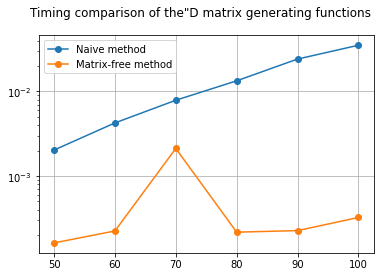

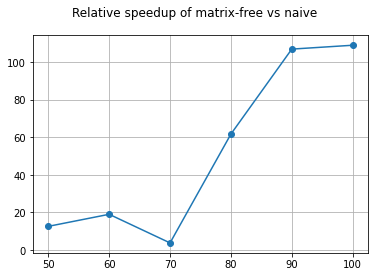

In [24]:
# do matrix-vector multiplication with matrix size varying between 50 and 100
# time the naive dot function and 


def timing_2d_compare() :
    
    prob_size=range(50,110,10)


    time1 = []
    time2 = []
    speedup = []
    
    iters = 10
    
    for s in prob_size:
        print(s)
        
        
        #assemble the matrices
        B,K,M,A = compute_one_dimensional_matrices(s)
        KK,MM,AA = compute_two_dimensional_matrices(s,K,M)
        
        time1_acc=0
        for i in range(0,iters+1):
            vec = np.random.uniform(low=-1, high=1, size=(s**2,))
            start = timer()
            AA.dot(vec)
            time1_acc += timer() - start
        
        time1.append( time1_acc/iters )
        
        time2_acc=0
        for i in range(0,iters+1):
            vec = np.random.uniform(low=-1, high=1, size=(s**2,))
            start = timer()
            matvec_matfree( vec, M, K )
            time2_acc += timer() - start
        
        time2.append( time2_acc/iters )
        
        
        speedup.append( time1_acc/time2_acc )
        



    print(time1)
    print(time2)
    
    plt.figure() 
    plt.grid()
    plt.suptitle('Timing comparison of the"D matrix generating functions')
    time1_h, = plt.semilogy(prob_size, time1, 'o-',label='Naive method')
    time2_h, = plt.semilogy(prob_size, time2, 'o-',label='Matrix-free method')
    plt.legend()
    plt.show()
    
    
    
    plt.figure() 
    plt.grid()
    plt.suptitle('Relative speedup of matrix-free vs naive')
    time1_h, = plt.plot(prob_size, speedup, 'o-',label='Naive method')
    #plt.legend()
    plt.show()
   
            

 
timing_2d_compare()

### 6. "Matrix free" evaluation for three dimensional problems (mandatory for MHPC, optional for others)

Looking at https://www.geeksforgeeks.org/running-python-script-on-gpu/, implement the same matrix free solver for three dimensional problems, exploiting just in time compilation, numba, and (optionally) GPU acceleration (if you have access to a GPU). 

Compare the timings you get for a fixed number of matrix vector products as n increases from 50 to 100 for the cases 

1. matrix based (assemble the three dimensional A, measure time of 100 A.dot(v)
2. matrix free, pure numpy (using techinque above, measure time 100 applications of matvec(v))
3. matrix free, numba+jit on CPU (measure time 100 applications of matvec(v))
4. (optional) matrix free, numba+jit on GPU (measure time 100 applications of matvec(v))

Comment on your findings.

In [42]:
# your code here

'''
copute directly the matrix-vector product even in the naive case 
because storing rank-6 tensors of 50+ elems per dimension is 
too much memory to handle for einsum
'''
def matvec_3D_naive(vinput,n, K, M):
    v = vinput.reshape((n,n,n))
    
    k1 = np.einsum('il, jm, kn, lmn -> ijk', K, M, M, v)
    k2 = np.einsum('il, jm, kn, lmn -> ijk', M, K, M, v)
    k3 = np.einsum('il, jm, kn, lmn -> ijk', M, M, K, v)
    m1 = np.einsum('il, jm, kn, lmn -> ijk', M, M, M, v)
    
    u = k1 + k2 + k3 + m1
    return u.reshape((n**3,))



def matvec_3D_matfree(vinput, n, K, M):
    v = vinput.reshape((n,n,n))
    
    vM = v.dot(M) 
    vK = v.dot(K)
    
    MvM = M.dot(vM)
    KvM = K.dot(vM)
    MvK = M.dot(vK)
    
    vk1 = K.dot(MvM)
    vk2 = M.dot(KvM)
    vk3 = M.dot(MvK)
    vm1 = M.dot(MvM)
    
    u = vk1 + vk2 + vk3 + vm1
    
    return u.reshape((n**3,))


@njit
def matvec_3D_matfree_jit(vinput, n, K, M):
    v = vinput.reshape((n,n,n))
    
    u = zeros((n,n,n),dtype=np.float64)
    Mv=zeros((n,n,n),dtype=np.float64)
    Kv=zeros((n,n,n),dtype=np.float64)
    MMv=zeros((n,n,n),dtype=np.float64)
    KMv=zeros((n,n,n),dtype=np.float64)
    MKv=zeros((n,n,n),dtype=np.float64)
    
    
    for k in range(0, n):
        for l in range(0, n):
            for m in range(0, n):
                for aux in range(0, n): 
                    Mv[k,l,m] += M[k,aux]*v[l,m,aux]
                    Kv[k,l,m] += K[k,aux]*v[l,m,aux]
                    
                
    for j in range(0, n):
        for k in range(0, n):
            for l in range(0, n):
                for aux in range(0, n):
                    MMv[j,k,l] += M[j,aux]*Mv[k,l,aux]
                    KMv[j,k,l] += K[j,aux]*Mv[k,l,aux]
                    MKv[j,k,l] += M[j,aux]*Kv[k,l,aux]
                    
    
    for i in range(0, n):
        for j in range(0, n):
            for k in range(0, n):
                for aux in range(0, n):
                    u[i,j,k] += K[i,aux]*MMv[j,k,aux]
                    u[i,j,k] += M[i,aux]*KMv[j,k,aux]
                    u[i,j,k] += M[i,aux]*MKv[j,k,aux]
                    u[i,j,k] += M[i,aux]*MMv[j,k,aux]
                    

                
    return u.reshape((n**3,))
    

@cuda.jit
def matvec_3D_matfree_cuda(vinput, n, K, M):
    v = vinput.reshape((n,n,n))
    
    u = cuda.shared.array(shape=(n, n, n), dtype=float32)
    Mv= cuda.shared.array(shape=(n, n, n), dtype=float32)
    Kv= cuda.shared.array(shape=(n, n, n), dtype=float32)
    MMv=cuda.shared.array(shape=(n, n, n), dtype=float32)
    KMv=cuda.shared.array(shape=(n, n, n), dtype=float32)
    MKv=cuda.shared.array(shape=(n, n, n), dtype=float32)
    
    
    for k in range(0, n):
        for l in range(0, n):
            for m in range(0, n):
                for aux in range(0, n): 
                    Mv[k,l,m] += M[k,aux]*v[l,m,aux]
                    Kv[k,l,m] += K[k,aux]*v[l,m,aux]
                    
                
    for j in range(0, n):
        for k in range(0, n):
            for l in range(0, n):
                for aux in range(0, n):
                    MMv[j,k,l] += M[j,aux]*Mv[k,l,aux]
                    KMv[j,k,l] += K[j,aux]*Mv[k,l,aux]
                    MKv[j,k,l] += M[j,aux]*Kv[k,l,aux]
                    
    
    for i in range(0, n):
        for j in range(0, n):
            for k in range(0, n):
                for aux in range(0, n):
                    u[i,j,k] += K[i,aux]*MMv[j,k,aux]
                    u[i,j,k] += M[i,aux]*KMv[j,k,aux]
                    u[i,j,k] += M[i,aux]*MKv[j,k,aux]
                    u[i,j,k] += M[i,aux]*MMv[j,k,aux]
                    

                
    return u.reshape((n**3,))    
    

    
'''
general code to store timings of $iter runs of the matrix-vector implementations
explicitly limited to size 20 since that's about the limit on a laptop
the large runs have been performed on the SISSA cluster using the same code
'''
all_n = np.arange(5,20,2)

naive_file = 'naive_out_times_log.txt'
matfree_file = 'matfree_out_times_log.txt'
matfree_jit_file = 'matfree_jit_out_times_log.txt'

iters = 10


naive_times_n = np.zeros((iters+1,np.size(all_n)), dtype=np.float64)
matfree_times_n = np.zeros((iters+1,np.size(all_n)), dtype=np.float64)
matfree_jit_times_n = np.zeros((iters+1,np.size(all_n)), dtype=np.float64)


for nn in range(0,np.size(all_n)):
    n = all_n[nn]
    print(n)

    naive_times_n[0,nn] = n
    matfree_times_n[0,nn] = n
    matfree_jit_times_n[0,nn] = n


    #get the one-dimensional matrices
    B,K,M,A = compute_one_dimensional_matrices(n)

    #AAA = compute_3D_matrices(n,K,M)

    for i in range(iters):


        vec = np.random.uniform(low=-1, high=1, size=(n**3,))

        start = timer()
        matvec_3D_naive(vec, n, K,M  )
        naive_times_n[i+1,nn] = (timer() - start)

        start = timer()
        matvec_3D_matfree(vec, n, K,M  )
        matfree_times_n[i+1,nn] = (timer() - start)


        start = timer()
        matvec_3D_matfree_jit(vec, n, K,M  )
        matfree_jit_times_n[i+1,nn] = (timer() - start)


np.savetxt(naive_file, naive_times_n, delimiter=',')
np.savetxt(matfree_file, matfree_times_n, delimiter=',')
np.savetxt(matfree_jit_file, matfree_jit_times_n, delimiter=',')
    

    #start = timer()
    #matvec_3D_matfree(vec, n, K,M  )
    #print(timer() - start)
#
#
    #start = timer()
    #matvec_3D_matfree_jit(vec, n, K,M  )
    #print(timer() - start)
#
    #start = timer()
    #matvec_3D_matfree_cuda(vec, n, K,M  )
    #print(timer() - start)

5
7
9
11
13
15
17
19
